In [1]:
import matplotlib.pylab as pylab
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import tqdm
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

submission = pd.read_csv('/content/drive/MyDrive/capstone/data/scaled_submission_Cheongdam_10years_3(interest).csv')
inversed_submission = pd.read_csv('/content/drive/MyDrive/capstone/data/inversed_submission_Cheongdam_10years_3(interest).csv')

wl = pd.read_csv('/content/drive/MyDrive/capstone/data/Han River Flood Hazard Standard Water Level.csv')
wl.rename(columns={'observatory': 'bridge_name'}, inplace=True)

In [3]:
# 시작 날짜와 끝 날짜 정의
start_date = '2010-01-01 00:00:00'
end_date = '2023-12-31 23:00:00'

# 날짜 범위 생성 (1시간 간격)
date_range = pd.date_range(start=start_date, end=end_date, freq='H')

# 생성된 날짜 범위 출력
print(date_range)

DatetimeIndex(['2010-01-01 00:00:00', '2010-01-01 01:00:00',
               '2010-01-01 02:00:00', '2010-01-01 03:00:00',
               '2010-01-01 04:00:00', '2010-01-01 05:00:00',
               '2010-01-01 06:00:00', '2010-01-01 07:00:00',
               '2010-01-01 08:00:00', '2010-01-01 09:00:00',
               ...
               '2023-12-31 14:00:00', '2023-12-31 15:00:00',
               '2023-12-31 16:00:00', '2023-12-31 17:00:00',
               '2023-12-31 18:00:00', '2023-12-31 19:00:00',
               '2023-12-31 20:00:00', '2023-12-31 21:00:00',
               '2023-12-31 22:00:00', '2023-12-31 23:00:00'],
              dtype='datetime64[ns]', length=122712, freq='H')


In [4]:
df_list = []
df_list2 = []

for bridge in inversed_submission['bridge_name'].unique():
    df = submission[submission['bridge_name']==bridge]
    df_2 = inversed_submission[inversed_submission['bridge_name']==bridge]
    df['datetime'] = date_range[:len(df)]
    df_2['datetime'] = date_range[:len(df_2)]
    df_list.append(df)
    df_list2.append(df_2)

submission = pd.concat(df_list)
inversed_submission = pd.concat(df_list2)

In [5]:
submission['datetime'] = pd.to_datetime(submission['datetime'])
inversed_submission['datetime'] = pd.to_datetime(inversed_submission['datetime'])

In [6]:
submission = pd.merge(submission, wl, on='bridge_name', how='left')
inversed_submission = pd.merge(inversed_submission, wl, on='bridge_name', how='left')

In [7]:
inversed_submission['anomaly'] = inversed_submission['true'] >= inversed_submission['interest']
inversed_submission

,true,predict,bridge_name,anomaly,datetime,interest,attention,caution,serious,latitude,longitude
0,1.05,1.074238,Cheongdam Bridge,False,2010-01-01 00:00:00,3.0,9.0,11.5,16.0,37.526074,127.064246
1,1.15,1.071026,Cheongdam Bridge,False,2010-01-01 01:00:00,3.0,9.0,11.5,16.0,37.526074,127.064246
2,1.28,1.382369,Cheongdam Bridge,False,2010-01-01 02:00:00,3.0,9.0,11.5,16.0,37.526074,127.064246
3,1.09,1.115944,Cheongdam Bridge,False,2010-01-01 03:00:00,3.0,9.0,11.5,16.0,37.526074,127.064246
4,1.08,1.151851,Cheongdam Bridge,False,2010-01-01 04:00:00,3.0,9.0,11.5,16.0,37.526074,127.064246
...,...,...,...,...,...,...,...,...,...,...,...
122622,1.06,1.070465,Cheongdam Bridge,False,2023-12-28 06:00:00,3.0,9.0,11.5,16.0,37.526074,127.064246
122623,1.06,1.040032,Cheongdam Bridge,False,2023-12-28 07:00:00,3.0,9.0,11.5,16.0,37.526074,127.064246
122624,1.04,1.071526,Cheongdam Bridge,False,2023-12-28 08:00:00,3.0,9.0,11.5,16.0,37.526074,127.064246
122625,1.04,1.055478,Cheongdam Bridge,False,2023-12-28 09:00:00,3.0,9.0,11.5,16.0,37.526074,127.064246


In [8]:
from sklearn.metrics import roc_curve, auc
def confusion_matrix(submission):
    confusion_df = pd.DataFrame()
    confusion_df['true'] = submission['true'] >= submission['interest'].iloc[0]
    confusion_df['predict'] = submission['predict'] >= submission['interest'].iloc[0]

    # TP, TN, FP, FN 계산
    TP = ((confusion_df['true'] == True) & (confusion_df['predict'] == True)).sum()
    TN = ((confusion_df['true'] == False) & (confusion_df['predict'] == False)).sum()
    FP = ((confusion_df['true'] == False) & (confusion_df['predict'] == True)).sum()
    FN = ((confusion_df['true'] == True) & (confusion_df['predict'] == False)).sum()

    print(f'TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}')
    # 정밀도 (Precision)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0

    # 재현율 (Recall)
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # F1 점수 (F1 Score)
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # 결과 출력
    print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1_score:.2f}')

    # ROC curve 계산
    fpr, tpr, _ = roc_curve(confusion_df['true'], confusion_df['predict'])
    roc_auc = auc(fpr, tpr)

    # ROC curve 그래프
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

TP: 3061, TN: 119076, FP: 155, FN: 335
Precision: 0.95, Recall: 0.90, F1 Score: 0.93


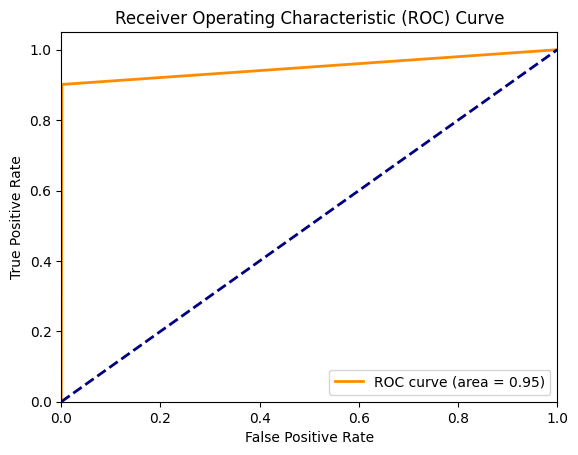

In [9]:
confusion_matrix(inversed_submission)

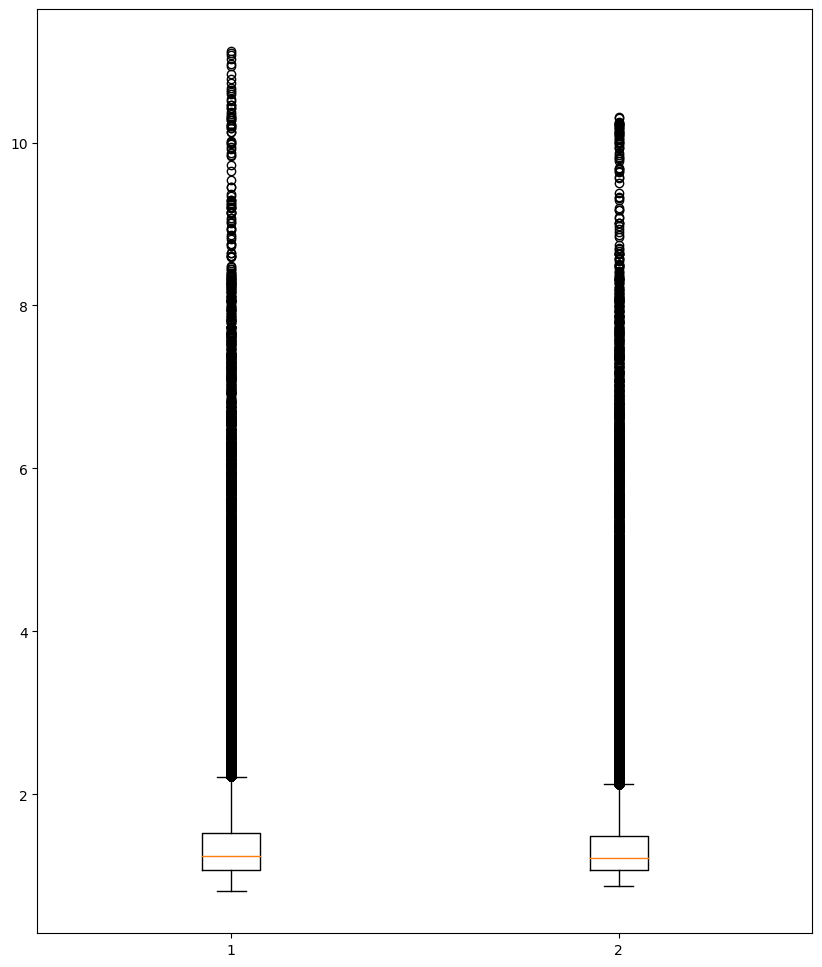

In [10]:
plt.figure(figsize=(10,12))
plt.boxplot(inversed_submission[['true', 'predict']])
plt.show()

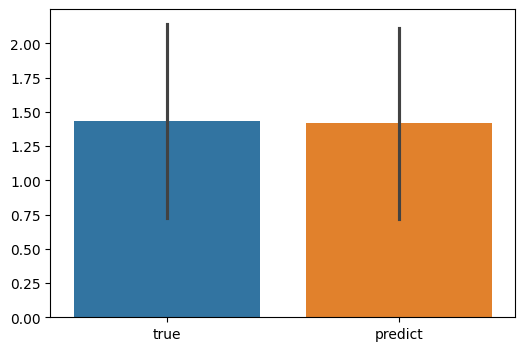

In [11]:
plt.figure(figsize=(6,4))
sns.barplot(inversed_submission[['true', 'predict']], ci='sd')
plt.show()

In [12]:
def evaluation(submission):
    eval = pd.DataFrame(columns=['bridge_name','anomaly_ratio(%)','R-squared', 'R-squared_adj','MAE','MSE','RMSE'])
    i=0
    for bridge in submission['bridge_name'].unique():
        df_bridge = inversed_submission[inversed_submission['bridge_name'] == bridge]
    #     df_anomaly = df[df['anomaly'] ==True]
        df_anomaly = df_bridge[df_bridge['interest'] < df_bridge['true']]

        true_values = df_anomaly['true']
        predicted_values = df_anomaly['predict']
        anomaly_ratio = round(len(df_anomaly)/len(df_bridge) * 100, 2)
        r_squared = r2_score(true_values, predicted_values)
        mae = mean_absolute_error(true_values, predicted_values)
        mse = mean_squared_error(true_values, predicted_values)
        rmse = np.sqrt(mse)

        n = len(true_values)
        p = 9
        adjusted_r2 = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

        eval.loc[i, 'anomaly_ratio(%)'] = anomaly_ratio
        eval.loc[i, 'bridge_name'] = bridge
        eval.loc[i, 'R-squared'] = r_squared
        eval.loc[i, 'R-squared_adj'] = adjusted_r2
        eval.loc[i, 'MAE'] = mae
        eval.loc[i, 'MSE'] = mse
        eval.loc[i, 'RMSE'] = rmse

        i += 1
    return eval

def visualization_anomaly(submission):
    length = len(submission['bridge_name'].unique())
    fig, axs = plt.subplots(length, 1, figsize=(15, 6*length))

    for i, bridge in enumerate(submission['bridge_name'].unique()):
        df_bridge = submission[submission['bridge_name'] == bridge].reset_index(drop=True)
        df_bridge.set_index('datetime', inplace=True)
        anomaly = df_bridge[df_bridge['interest'] < df_bridge['true']]

        axs[i].scatter(anomaly.index, anomaly['true'], marker='x', label='True')
        axs[i].scatter(anomaly.index, anomaly['predict'], marker='o',label='Predict')
        axs[i].set_title(bridge + ' anomaly only')
        axs[i].axhline(y=df_bridge['interest'].iloc[0], color='g', linestyle='--', label='interest')
#         axs[i].axhline(y=df_bridge['attention'].iloc[0], color='y', linestyle='--', label='attention')
#         axs[i].axhline(y=df_bridge['caution'].iloc[0], color='orange', linestyle='--', label='caution')
#         axs[i].axhline(y=df_bridge['serious'].iloc[0], color='r', linestyle='--', label='serious')
        axs[i].legend()
    plt.show()

In [13]:
evaluation(inversed_submission)

,bridge_name,anomaly_ratio(%),R-squared,R-squared_adj,MAE,MSE,RMSE
0,Cheongdam Bridge,2.77,0.950329,0.950197,0.239462,0.118685,0.344507


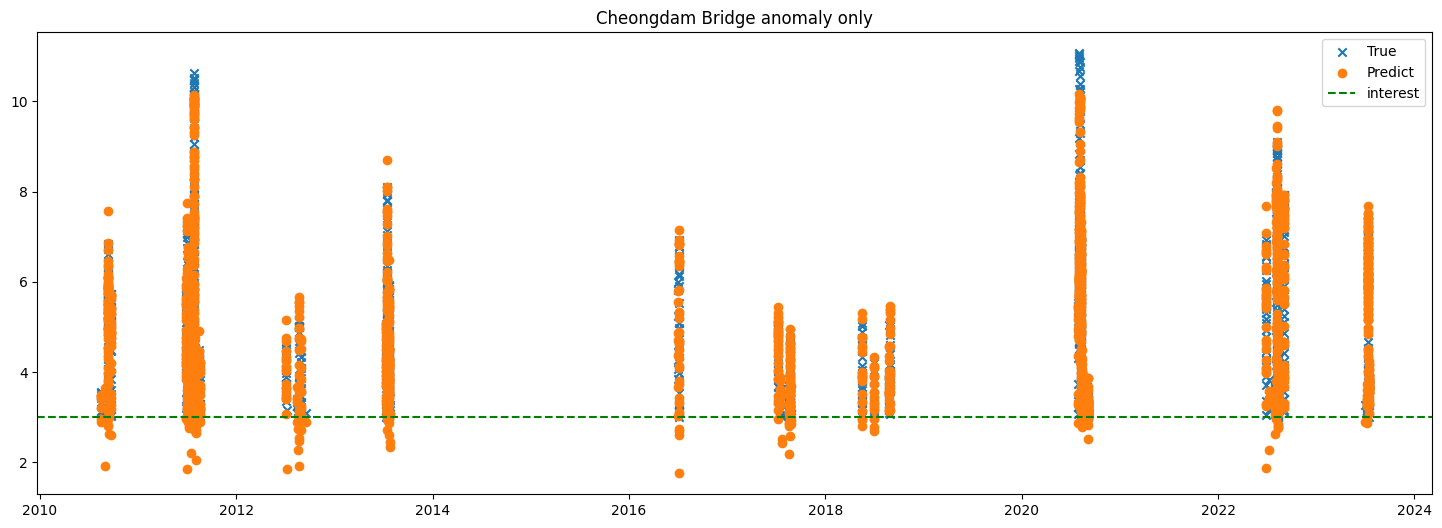

In [14]:
plt.figure(figsize=(18, 6))  # 그림의 크기를 너비 10인치, 높이 6인치로 설정

df_bridge = submission[submission['bridge_name'] == bridge].reset_index(drop=True)
df_bridge.set_index('datetime', inplace=True)
anomaly = df_bridge[df_bridge['interest'] < df_bridge['true']]

plt.scatter(anomaly.index, anomaly['true'], marker='x', label='True', linestyle='solid')
plt.scatter(anomaly.index, anomaly['predict'], marker='o',label='Predict',linestyle='solid')
plt.title(bridge + ' anomaly only')
plt.axhline(y=df_bridge['interest'].iloc[0], color='g', linestyle='--', label='interest')
plt.legend()
plt.show()

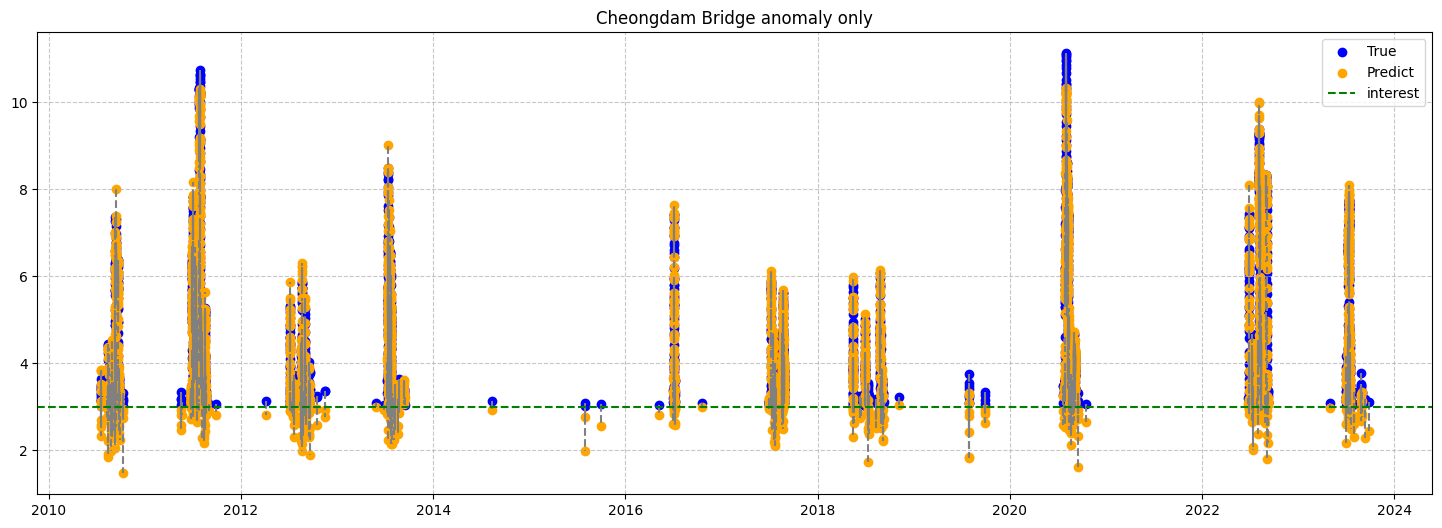

In [15]:
plt.figure(figsize=(18, 6))  # 그림의 크기를 너비 18인치, 높이 6인치로 설정

# 데이터프레임 생성
df_bridge = inversed_submission[inversed_submission['bridge_name'] == bridge].reset_index(drop=True)
df_bridge['year'] = df_bridge['datetime'].dt.year

inversed_submission.set_index('datetime', inplace=True)
anomaly = inversed_submission[inversed_submission['interest'] < inversed_submission['true']]

# true와 predict 간의 대응되는 점 찾기
common_index = anomaly.index.intersection(anomaly.index)

# true와 predict 값 표시
plt.scatter(anomaly.loc[common_index].index, anomaly.loc[common_index, 'true'], marker='o', color='blue', label='True')
plt.scatter(anomaly.loc[common_index].index, anomaly.loc[common_index, 'predict'], marker='o', color='orange', label='Predict')

# true와 predict 값을 서로 연결하는 선 추가
for idx in common_index:
    plt.plot([idx, idx], [anomaly.loc[idx, 'true'], anomaly.loc[idx, 'predict']], color='gray', linestyle='--')

plt.axhline(y=df_bridge['interest'].iloc[0], color='g', linestyle='--', label='interest')

# 그리드 추가
plt.grid(True, linestyle='--', alpha=0.7)

# 그래프 타이틀 설정
plt.title(bridge + ' anomaly only')

# 범례 추가
plt.legend()

# 그래프 보여주기
plt.show()


In [22]:
years = df_bridge['year'].unique()
plt.figure(figsize=(18, 6))

for i, year in enumerate(years):
    plt.figure(figsize=(18, 6))  # New figure for each year
    yearly_data = df_bridge[df_bridge['year'] == year]
    anomaly = yearly_data[yearly_data['interest'] < yearly_data['true']]
    anomaly.set_index('datetime', inplace=True)
    common_index = anomaly.index.intersection(anomaly.index)

    plt.scatter(anomaly.loc[common_index].index, anomaly.loc[common_index, 'true'], marker='o', color='blue', label='True')
    plt.scatter(anomaly.loc[common_index].index, anomaly.loc[common_index, 'predict'], marker='o', color='orange', label='Predict')

    for idx in common_index:
        plt.plot([idx, idx], [anomaly.loc[idx, 'true'], anomaly.loc[idx, 'predict']], color='gray', linestyle='--')

    plt.axhline(y=yearly_data['interest'].iloc[0], color='g', linestyle='--', label='interest')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.title(f"{bridge} anomaly only - {year}")

    # Reset legend by removing it if it exists
    ax = plt.gca()
    if ax.legend_:
        ax.legend_.remove()

    plt.legend()
    plt.tight_layout()
    plt.savefig(f'/content/drive/MyDrive/capstone/[interest]Cheongdam_{year}.png')
    plt.close()  # Close the figure to free up memory and avoid overlap

plt.show()

<Figure size 1800x600 with 0 Axes>

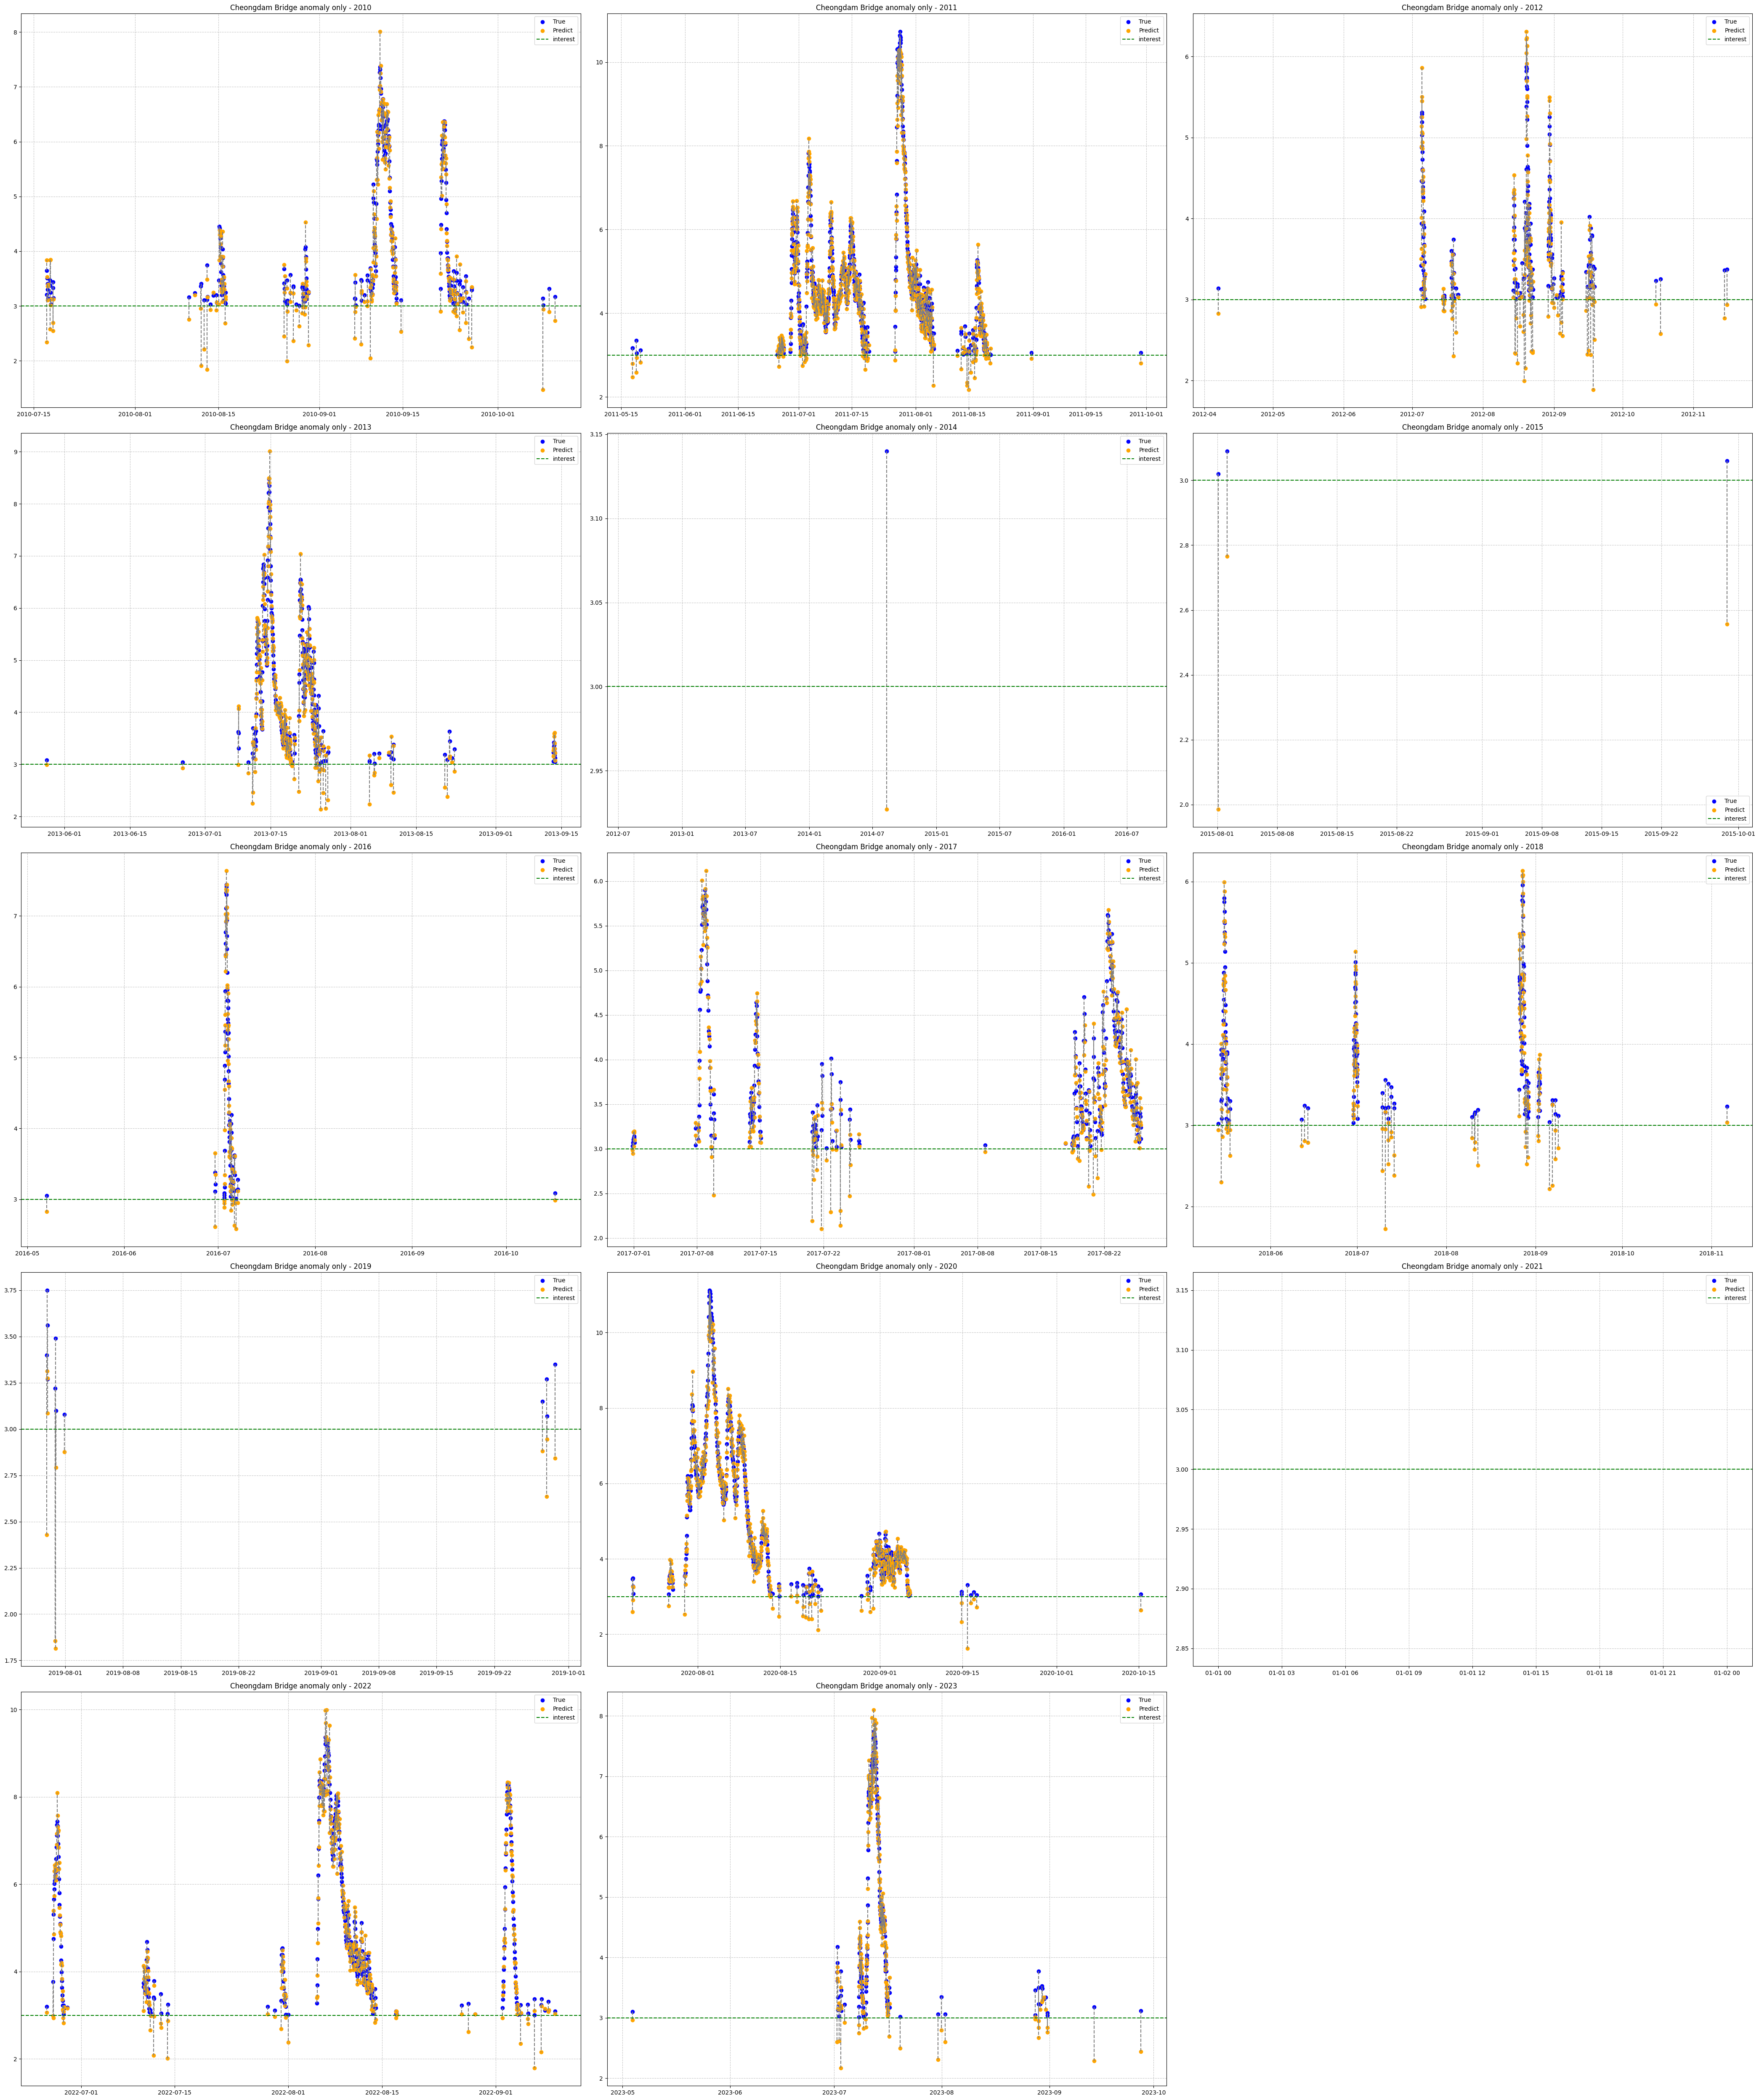

In [23]:
# 연도별 고유 값 추출
years = df_bridge['year'].unique()

# 행과 열 계산 (3열로 설정)
n_cols = 3
n_rows = (len(years) + n_cols - 1) // n_cols  # 올림 처리

fig, axs = plt.subplots(n_rows, n_cols, figsize=(42, 10 * n_rows))

# 각 연도별로 서브플롯에 데이터 그리기
for i, year in enumerate(years):
    yearly_data = df_bridge[df_bridge['year'] == year]
    anomaly = yearly_data[yearly_data['interest'] < yearly_data['true']]
    anomaly.set_index('datetime', inplace=True)
    common_index = anomaly.index.intersection(anomaly.index)

    row, col = divmod(i, n_cols)
    axs[row, col].scatter(anomaly.loc[common_index].index, anomaly.loc[common_index, 'true'], marker='o', color='blue', label='True')
    axs[row, col].scatter(anomaly.loc[common_index].index, anomaly.loc[common_index, 'predict'], marker='o', color='orange', label='Predict')
    if(anomaly.empty != True):
        for idx in common_index:
            axs[row, col].plot([idx, idx], [anomaly.loc[idx, 'true'], anomaly.loc[idx, 'predict']], color='gray', linestyle='--')

    axs[row, col].axhline(y=yearly_data['interest'].iloc[0], color='g', linestyle='--', label='interest')
    axs[row, col].grid(True, linestyle='--', alpha=0.7)
    axs[row, col].set_title(f"{bridge} anomaly only - {year}")
    axs[row, col].legend()

# 사용되지 않은 서브플롯 숨기기
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axs.flatten()[j])

# 그래프 간 간격 자동 조정
plt.tight_layout()
plt.show()

In [18]:
# length = len(inversed_submission['bridge_name'].unique())
# fig, axs = plt.subplots(length, 2, figsize=(30, 50))

# for i, bridge in enumerate(inversed_submission['bridge_name'].unique()):
#     df_bridge = inversed_submission[inversed_submission['bridge_name'] == bridge].reset_index(drop=True)
#     anomaly = df_bridge[df_bridge['interest'] < df_bridge['true']]
#     print(bridge, 'Anomaly Count : ', len(anomaly), ',  ', round(len(anomaly)/len(df_bridge) * 100, 2),'%')
#     axs[i,0].plot(df_bridge['true'], label='True')
#     axs[i,0].plot(df_bridge['predict'], label='Predicted')
#     axs[i,1].scatter(anomaly.index, anomaly['true'], marker='x', label='True')
#     axs[i,1].scatter(anomaly.index, anomaly['predict'], marker='o',label='Predict')
#     axs[i, 0].set_title(bridge)
#     axs[i, 1].set_title(bridge + ' anomaly only')
#     axs[i, 0].axhline(y=df_bridge['interest'].iloc[0], color='r', linestyle='--', label='Anomaly (interest)')
#     axs[i, 1].axhline(y=df_bridge['interest'].iloc[0], color='r', linestyle='--', label='Anomaly (interest)')
#     axs[i,0].legend()
#     axs[i,1].legend()
# plt.show()


In [19]:
# # 일 평균 수위

# eval = pd.DataFrame(columns=['bridge_name','anomaly_ratio','R-squared','MAE','MSE','RMSE'])

# for bridge in inversed_submission['bridge_name'].unique():
#     df_bridge = inversed_submission[inversed_submission['bridge_name'] == bridge].reset_index(drop=True)
#     interest = df_bridge['interest'].iloc[0]
#     df_bridge.set_index('datetime', inplace=True)
#     daily_mean = df_bridge[['true', 'predict']].resample('D').mean()
#     mean_anomaly = daily_mean[daily_mean['true'] > interest]

#     true_values = mean_anomaly['true']
#     predicted_values = mean_anomaly['predict']

#     if(len(true_values) > 0):
#         r_squared = r2_score(true_values.values, predicted_values.values)
#         mae = mean_absolute_error(true_values.values, predicted_values.values)
#         mse = mean_squared_error(true_values.values, predicted_values.values)
#         rmse = np.sqrt(mse)
#         anomaly_ratio = len(mean_anomaly)/len(daily_mean)*100

#         eval.loc[i, 'bridge_name'] = bridge
#         eval.loc[i, 'anomaly_ratio']=round(anomaly_ratio, 2)
#         eval.loc[i, 'R-squared'] = r_squared
#         eval.loc[i, 'MAE'] = mae
#         eval.loc[i, 'MSE'] = mse
#         eval.loc[i, 'RMSE'] = rmse
#         i += 1


# length = len(inversed_submission['bridge_name'].unique())
# fig, axs = plt.subplots(length, 1, figsize=(15, 6*length))

# for i, bridge in enumerate(inversed_submission['bridge_name'].unique()):
#     df_bridge = inversed_submission[inversed_submission['bridge_name'] == bridge].reset_index(drop=True)
#     interest= df_bridge['interest'].iloc[0]
#     df_bridge.set_index('datetime', inplace=True)
#     daily_mean = df_bridge[['true', 'predict']].resample('D').mean()
#     mean_anomaly = daily_mean[daily_mean['true'] > interest]

# #     anomaly = df_bridge[df_bridge['anomaly'] == True]
# #     print(bridge, 'Anomaly Count : ', len(anomaly), ',  ', round(len(anomaly)/len(df_bridge) * 100, 2),'%')

#     axs[i].scatter(mean_anomaly.index, mean_anomaly['true'], marker='x', label='true')
#     axs[i].scatter(mean_anomaly.index, mean_anomaly['predict'], marker='o',label='predict')

#     axs[i].axhline(y=interest, color='r', linestyle='--', label='interest')

#     axs[i].set_title(bridge + ' anomaly only')
#     axs[i].legend()

# eval

In [20]:
# # 일 최고 수위

# eval = pd.DataFrame(columns=['bridge_name','anomaly_ratio','R-squared','MAE','MSE','RMSE'])

# for bridge in inversed_submission['bridge_name'].unique():
#     df_bridge = inversed_submission[inversed_submission['bridge_name'] == bridge].reset_index(drop=True)
#     interest = df_bridge['interest'].iloc[0]
#     df_bridge.set_index('datetime', inplace=True)
#     daily_mean = df_bridge[['true', 'predict']].resample('D').max()
#     mean_anomaly = daily_mean[daily_mean['true'] > interest]

#     true_values = mean_anomaly['true']
#     predicted_values = mean_anomaly['predict']

#     if(len(true_values) > 0):
#         r_squared = r2_score(true_values.values, predicted_values.values)
#         mae = mean_absolute_error(true_values.values, predicted_values.values)
#         mse = mean_squared_error(true_values.values, predicted_values.values)
#         rmse = np.sqrt(mse)
#         anomaly_ratio = len(mean_anomaly)/len(daily_mean)*100

#         eval.loc[i, 'bridge_name'] = bridge
#         eval.loc[i, 'anomaly_ratio']=round(anomaly_ratio, 2)
#         eval.loc[i, 'R-squared'] = r_squared
#         eval.loc[i, 'MAE'] = mae
#         eval.loc[i, 'MSE'] = mse
#         eval.loc[i, 'RMSE'] = rmse
#         i += 1


# length = len(inversed_submission['bridge_name'].unique())
# fig, axs = plt.subplots(length, 1, figsize=(15, 6*length))

# for i, bridge in enumerate(inversed_submission['bridge_name'].unique()):
#     df_bridge = inversed_submission[inversed_submission['bridge_name'] == bridge].reset_index(drop=True)
#     interest= df_bridge['interest'].iloc[0]
#     df_bridge.set_index('datetime', inplace=True)
#     daily_mean = df_bridge[['true', 'predict']].resample('D').max()
#     mean_anomaly = daily_mean[daily_mean['true'] > interest]

# #     anomaly = df_bridge[df_bridge['anomaly'] == True]
# #     print(bridge, 'Anomaly Count : ', len(anomaly), ',  ', round(len(anomaly)/len(df_bridge) * 100, 2),'%')

#     axs[i].scatter(mean_anomaly.index, mean_anomaly['true'], marker='x', label='true')
#     axs[i].scatter(mean_anomaly.index, mean_anomaly['predict'], marker='o',label='predict')

#     axs[i].axhline(y=interest, color='r', linestyle='--', label='interest')

#     axs[i].set_title(bridge + ' anomaly only')
#     axs[i].legend()

# eval

In [21]:
# # 일 최저 수위

# eval = pd.DataFrame(columns=['bridge_name','anomaly_ratio','R-squared','MAE','MSE','RMSE'])

# for bridge in inversed_submission['bridge_name'].unique():
#     df_bridge = inversed_submission[inversed_submission['bridge_name'] == bridge].reset_index(drop=True)
#     interest = df_bridge['interest'].iloc[0]
#     df_bridge.set_index('datetime', inplace=True)
#     daily_mean = df_bridge[['true', 'predict']].resample('D').min()
#     mean_anomaly = daily_mean[daily_mean['true'] > interest]

#     true_values = mean_anomaly['true']
#     predicted_values = mean_anomaly['predict']

#     if(len(true_values) > 0):
#         r_squared = r2_score(true_values.values, predicted_values.values)
#         mae = mean_absolute_error(true_values.values, predicted_values.values)
#         mse = mean_squared_error(true_values.values, predicted_values.values)
#         rmse = np.sqrt(mse)
#         anomaly_ratio = len(mean_anomaly)/len(daily_mean)*100

#         eval.loc[i, 'bridge_name'] = bridge
#         eval.loc[i, 'anomaly_ratio']=round(anomaly_ratio, 2)
#         eval.loc[i, 'R-squared'] = r_squared
#         eval.loc[i, 'MAE'] = mae
#         eval.loc[i, 'MSE'] = mse
#         eval.loc[i, 'RMSE'] = rmse
#         i += 1


# length = len(inversed_submission['bridge_name'].unique())
# fig, axs = plt.subplots(length, 1, figsize=(15, 6*length))

# for i, bridge in enumerate(inversed_submission['bridge_name'].unique()):
#     df_bridge = inversed_submission[inversed_submission['bridge_name'] == bridge].reset_index(drop=True)
#     interest= df_bridge['interest'].iloc[0]
#     df_bridge.set_index('datetime', inplace=True)
#     daily_mean = df_bridge[['true', 'predict']].resample('D').min()
#     mean_anomaly = daily_mean[daily_mean['true'] > interest]

# #     anomaly = df_bridge[df_bridge['anomaly'] == True]
# #     print(bridge, 'Anomaly Count : ', len(anomaly), ',  ', round(len(anomaly)/len(df_bridge) * 100, 2),'%')

#     axs[i].scatter(mean_anomaly.index, mean_anomaly['true'], marker='x', label='true')
#     axs[i].scatter(mean_anomaly.index, mean_anomaly['predict'], marker='o',label='predict')

#     axs[i].axhline(y=interest, color='r', linestyle='--', label='interest')

#     axs[i].set_title(bridge + ' anomaly only')
#     axs[i].legend()

# eval